In [10]:
#!/usr/bin/python
# by DBR 2/2017 #

%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from all_models import *
from scipy.stats import norm
from time import time

plt.style.use('ggplot')

#upload data
prim_df = pd.DataFrame.from_csv('data/prim_df.csv')
prim_weeks = pd.DataFrame.from_csv('data/prim_weeks.csv')
ATI_df = pd.DataFrame.from_csv('data/ATI_df.csv')
ATI_weeks = pd.DataFrame.from_csv('data/ATI_weeks.csv')

#names of 8 good rebounds
ATI_list = [['Z09087','Z09106','Z09192','Z09204'],
            ['Z09144','Z08214','A11200','Z09196']] 

#colors for plotting
cz=[['darkcyan','indigo','blue', 'royalblue'],
    ['indianred', 'darkred', 'salmon', 'red']]

#make the color/marker lists
cz_list=[]; mz_list=[]
cind=0; tind=0;
for m in range(25):
    if prim_df.keys()[m] in ATI_list[0]:
        mz_list.append('s')
        cz_list.append(cz[0][cind])
        cind+=1
    elif prim_df.keys()[m] in ATI_list[1]:
        mz_list.append('>')
        cz_list.append(cz[1][tind])
        tind+=1
    else:
        mz_list.append('o')
        cz_list.append('gray')

#parameters we fit for primary infection aS,dS,dE,E50,w,k,S0,E0
param_names=[
    r'$\alpha_S$',
    r'$\delta_S$',
    r'$\delta_E$',
    r'$E_{50}$',
    r'$\omega$',
    r'$\kappa$',
    r'$S_0$',
    r'$E_0$']


In [11]:
#function to make bounds nicely with consistent bounds for each parameter
def make_bounds(guess,fac):
    bounds=tuple([tuple(np.array(guess)/fac),tuple(np.array(guess)*fac)])
    return bounds

#makes bounds including variable bound factors for each parameter
def make_bounds_variable(guess,fac_list):
    ub=[]; lb=[]
    for i in range(len(guess)):
        ub.append(guess[i]*fac_list[i])
        lb.append(guess[i]/fac_list[i])
        bounds=tuple([tuple(np.array(lb)),tuple(np.array(ub))])
    return bounds
        
#function to fit model 1 with pegged parameters
def fit1(tt,aS,dS,dE,E50,w,k,S0,E0):
    
    #initial conditions that are always true regardless of model
    U0=0      #no infected cells
    P0=0      #productively infected cells
    V0=0.03   #start with 30 copies per mL
    
    Bt=1e-4; dI=1; tau=0.05; p=5e4; g=23; aE=1e-4; #pegged parameters
    
    sol=odeint(model_1, [S0,U0,P0,E0,V0], tt, (aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    logV=np.log10(sol[:,4]*1e3) #log viral load copies per mL
    
    return logV

#function to plot other states with same model (still pegged parameters)
def solve1(tt,aS,dS,dE,E50,w,k,S0,E0):
    
    #initial conditions that are always true regardless of model
    U0=0      #no infected cells
    P0=0      #productively infected cells
    V0=0.03   #start with 30 copies per mL
    
    Bt=1e-4; dI=1; tau=0.05; p=5e4; g=23; aE=1e-4; #pegged parameters

    sol=odeint(model_1, [S0,U0,P0,E0,V0], tt, (aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    
    return sol


In [12]:
#do the fit

aS = 100;   #constant growth rate of susceptibles [cells/uL/day]
dS = 0.3;   #susceptible death rate [1/day] 
k  = 0.01;  #immune cell killing rate [1/day]
w  = 0.01;  #immune cell multiplier [1/day]
dE = 0.01; #immune death rate [1/day]
E50= 250;   #50 pct max E cell concentration [cells/uL]
S0 = 200;   #initial susceptible [cells/uL]
E0 = 1;     #initial cytolytic [cells/uL]

guess=aS,dS,dE,E50,w,k,S0,E0

m_list=range(25) #which to model

#loop through each monkey and fit VL
po_arr=np.zeros([len(guess),25]); pc_arr=np.zeros([len(guess),len(guess),25]); #intialize arrays
for m in m_list:

    t_data = prim_weeks.values[:,0]*7 #put in days scale
    V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data

    #model 1 fit
    po, pc = curve_fit(fit1, t_data, V_data, p0=guess, bounds=make_bounds(guess,1000),sigma=1,absolute_sigma=True,
                        max_nfev=1e3, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)

    po_arr[:,m]=po
    pc_arr[:,:,m]=pc
    

`xtol` termination condition is satisfied.
Function evaluations: 36, initial cost: 2.4785e+01, final cost 6.0955e-01, first-order optimality 5.00e+00.
`xtol` termination condition is satisfied.
Function evaluations: 39, initial cost: 6.0363e+01, final cost 8.7527e-01, first-order optimality 7.71e+02.
`xtol` termination condition is satisfied.
Function evaluations: 43, initial cost: 1.1947e+02, final cost 4.0084e+00, first-order optimality 7.08e+03.
`xtol` termination condition is satisfied.
Function evaluations: 39, initial cost: 2.1481e+02, final cost 4.5741e+00, first-order optimality 2.56e+04.
`xtol` termination condition is satisfied.
Function evaluations: 47, initial cost: 1.5541e+02, final cost 2.2108e+00, first-order optimality 3.43e+03.
`xtol` termination condition is satisfied.
Function evaluations: 47, initial cost: 3.4436e+01, final cost 1.7627e+00, first-order optimality 5.76e+01.
`xtol` termination condition is satisfied.
Function evaluations: 38, initial cost: 8.4422e+01,

/Users/danielreeves/anaconda/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


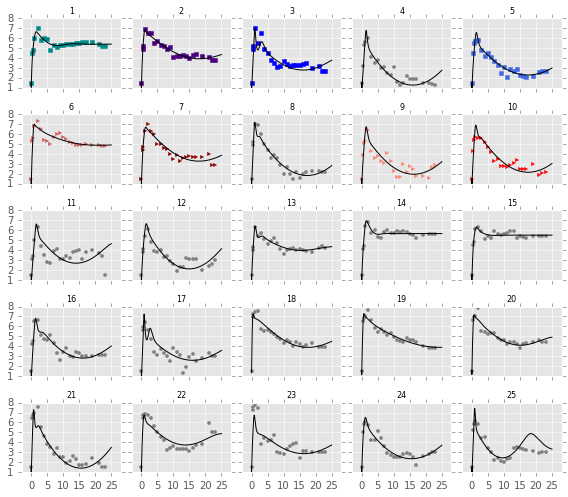

In [13]:
#plot viral load fits
fig,axarr = plt.subplots(5,5,sharex=True,sharey=True,figsize=(8,7),dpi=600)
cind=0; tind=0

tt=np.linspace(0,25*7,1e4)
    
for m in range(25):
    t_data = prim_weeks.values[:,0]*7 #put in days scale
    V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data

    aS,dS,dE,E50,w,k,S0,E0=po_arr[:,m]
    
    logV=fit1(tt,aS,dS,dE,E50,w,k,S0,E0) #solution with optimal params
    
    ax=axarr[int(np.floor(m/5))][m%5]
    ax.scatter(t_data/7,V_data,color=cz_list[m],alpha=1,s=10,marker=mz_list[m])
    ax.plot(tt/7,logV,color='black',linewidth=1)
    ax.set_title(m+1,fontsize=8)
    
plt.xlim([-3,28])
plt.ylim([1,8])
plt.tight_layout()
plt.savefig('figures/fits_primary.pdf')



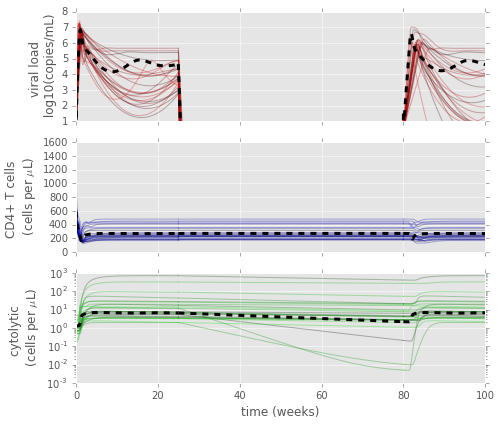

In [14]:
#simulating the whole trajectory given the ART intervention etc

fig1,ax = plt.subplots(3,1,figsize=(7,6),sharex=True,dpi=600)
cc=np.linspace(0.1,0.9,25) #color index
alz=0.3
S_ATI_list=[]; E_ATI_list=[];
for m in range(25):

    aS,dS,dE,E50,w,k,S0,E0=po_arr[:,m]

    #initial conditions that are always true regardless of model
    U0=0      #no infected cells
    P0=0      #productively infected cells
    V0=0.03   #start with 30 copies per mL
    
    Bt=1e-4; dI=1; tau=0.05; p=5e4; g=23; aE=1e-4; #pegged parameters

    t1=np.linspace(0,25*7,1e3) #week timeseries
    t2=np.linspace(25*7,80*7,1e3) #week timeseries
    t3=np.linspace(80*7,100*7,1e3) #week timeseries

    #change this part accordingly for which model one wants to simulate
    sol1=odeint(model_1, [S0,U0,P0,E0,V0], t1, 
               (aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    sol2=odeint(model_1, [sol1[-1,0],sol1[-1,1],sol1[-1,2],sol1[-1,3],sol1[-1,4]], t2, 
               (aS,dS,Bt/10,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    sol3=odeint(model_1, [sol2[-1,0],U0,P0,sol2[-1,3],V0], t3, 
               (aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    
    S_ATI_list.append(sol2[-1,0]); E_ATI_list.append(sol2[-1,3]); #simulate initial conditions for later
    
    ax[0].plot(t1/7,np.log10(sol1[:,4]*1e3),color=[cc[m],0,0],alpha=alz)
    ax[0].plot(t2/7,np.log10(sol2[:,4]*1e3),color=[cc[m],0,0],alpha=alz)
    ax[0].plot(t3/7,np.log10(sol3[:,4]*1e3),color=[cc[m],0,0],alpha=alz)
    
    ax[1].plot(t1/7,sol1[:,0]+sol1[:,1]+sol1[:,2],color=[0,0,cc[m]],alpha=alz)
    ax[1].plot(t2/7,sol2[:,0]+sol2[:,1]+sol2[:,2],color=[0,0,cc[m]],alpha=alz)
    ax[1].plot(t3/7,sol3[:,0]+sol3[:,1]+sol3[:,2],color=[0,0,cc[m]],alpha=alz)

    ax[2].semilogy(t1/7,sol1[:,3],color=[0,cc[m],0],alpha=alz)
    ax[2].semilogy(t2/7,sol2[:,3],color=[0,cc[m],0],alpha=alz)
    ax[2].semilogy(t3/7,sol3[:,3],color=[0,cc[m],0],alpha=alz)

    
#mean values
aS,dS,dE,E50,w,k,S0,E0=np.mean(po_arr,1)
sol1=odeint(model_1, [S0,U0,P0,E0,V0], t1, 
           (aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
sol2=odeint(model_1, [sol1[-1,0],sol1[-1,1],sol1[-1,2],sol1[-1,3],sol1[-1,4]], t2, 
           (aS,dS,Bt/10,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
sol3=odeint(model_1, [sol2[-1,0],0,0,sol2[-1,3],0.03], t3, 
           (aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)

ax[0].plot(t1/7,np.log10(sol1[:,4]*1e3),color='k',lw=3,ls='--')
ax[0].plot(t2/7,np.log10(sol2[:,4]*1e3),color='k',lw=3,ls='--')
ax[0].plot(t3/7,np.log10(sol3[:,4]*1e3),color='k',lw=3,ls='--')

ax[1].plot(t1/7,sol1[:,0]+sol1[:,1]+sol1[:,2],color='k',lw=3,ls='--')
ax[1].plot(t2/7,sol2[:,0]+sol2[:,1]+sol2[:,2],color='k',lw=3,ls='--')
ax[1].plot(t3/7,sol3[:,0]+sol3[:,1]+sol3[:,2],color='k',lw=3,ls='--')

ax[2].semilogy(t1/7,sol1[:,3],color='k',lw=3,ls='--')
ax[2].semilogy(t2/7,sol2[:,3],color='k',lw=3,ls='--')
ax[2].semilogy(t3/7,sol3[:,3],color='k',lw=3,ls='--')

ax[0].set_ylim(1,8)
ax[0].set_ylabel('viral load \n log10(copies/mL)')
ax[1].set_ylabel('CD4+ T cells \n (cells per $\mu$L)')
ax[2].set_ylabel('cytolytic \n (cells per $\mu$L)')
ax[2].set_xlabel('time (weeks)')

plt.tight_layout()
plt.savefig('figures/sim_full.pdf')  # No warning now


parameter & mean value & between animal std dev & fitting std dev \\
$\alpha_S$ & 132.11 & 48.675 & 64.948 \\
$\delta_S$ & 0.485 & 0.131 & 0.199 \\
$\delta_E$ & 0.003 & 0.006 & 0.007 \\
$E_{50}$ & 281.253 & 84.383 & 159.359 \\
$\omega$ & 1.881 & 0.573 & 0.932 \\
$\kappa$ & 0.291 & 0.263 & 2.886 \\
$S_0$ & 591.709 & 262.451 & 208.147 \\
$E_0$ & 1.294 & 0.957 & 4.566 \\


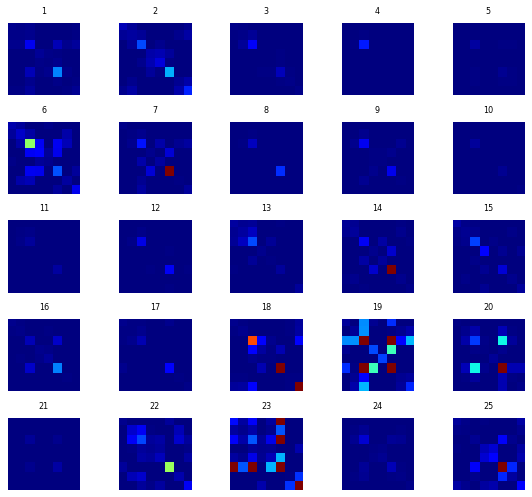

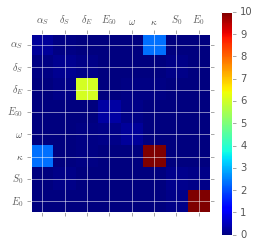

In [15]:
#show all the fitting covariance matrices
fig1,axarr = plt.subplots(5,5,figsize=(8,7),dpi=600)

maxz=10 #limit of colorbar

#for each monkey
for m in m_list:
    ax=axarr[int(np.floor(m/5))][m%5]
    bp=po_arr[:,m] #best parameter set
    mean_sq = np.transpose(np.matrix(bp))*np.matrix(bp)#matrix of param values to normalize
    f=ax.matshow(pc_arr[:,:,m]/mean_sq)
    f.set_clim([0,maxz])
    ax.set_yticks([]); ax.set_xticks([]) #ticks off
    ax.set_title(m+1,fontsize=8)
plt.tight_layout()
plt.savefig('figures/cov_primary_all.pdf')  # No warning now

#plot the mean covariance matrix
fig2=plt.figure(figsize=(5,2),dpi=600)
bp_mean=np.mean(po_arr,1)
bp_std=np.std(po_arr,1)
C=np.mean(pc_arr,2)
mean_sq = np.transpose(np.matrix(bp_mean))*np.matrix(bp_mean) #matrix of mean param values to normalize
plt.matshow(C/mean_sq)
plt.yticks(range(8),param_names)
plt.xticks(range(8),param_names)
plt.clim(0,maxz)
plt.colorbar()
plt.savefig('figures/cov_primary_mean.pdf')

print('parameter & mean value & between animal std dev & fitting std dev',r'\\')
#make the latex table for across animals
for i in range(len(param_names)):
    print(param_names[i],'&',np.round(bp_mean[i],3),'&',np.round(bp_std[i],3),'&',np.round(np.sqrt(np.diag(C))[i],3),r'\\')


In [16]:
#initialize the parameter arrays for ATI
po_arrA=np.zeros([len(guess),8]); 
pc_arrA=np.zeros([len(guess),len(guess),8]);

mati=[0,1,2,4,5,6,8,9] #the indexs of the ATI monkeys


1.20696278275
`xtol` termination condition is satisfied.
Function evaluations: 31, initial cost: 8.8599e+00, final cost 2.5224e+00, first-order optimality 1.14e+02.
3.54628516765
`xtol` termination condition is satisfied.
Function evaluations: 36, initial cost: 3.1566e+01, final cost 8.7633e-01, first-order optimality 6.18e-01.
7.27862744245
`xtol` termination condition is satisfied.
Function evaluations: 40, initial cost: 1.7761e+01, final cost 1.2755e+00, first-order optimality 1.49e+00.
3.79753818115
`xtol` termination condition is satisfied.
Function evaluations: 35, initial cost: 1.7405e+01, final cost 9.9338e-01, first-order optimality 6.78e+00.
`xtol` termination condition is satisfied.
Function evaluations: 30, initial cost: 7.6189e+00, final cost 3.9960e-01, first-order optimality 5.28e-01.
`xtol` termination condition is satisfied.
Function evaluations: 35, initial cost: 1.1630e+01, final cost 4.6623e-01, first-order optimality 5.72e-03.
`xtol` termination condition is satisf

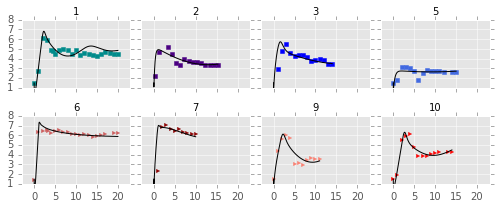

In [20]:
#Modeling rebound infection data
fig,axarr = plt.subplots(2,4,sharex=True,sharey=True,figsize=(7,3),dpi=600)

for i in range(8):
    V_data = np.log10(ATI_df[ATI_df.columns[i]].interpolate(method='linear',axis=0,limit=1).dropna(axis=0))
    t_temp = ATI_weeks.iloc[:,i]-ATI_weeks.min()[i]
    t_data = t_temp[V_data.index]*7
    
    aS,dS,dE,E50,w,k,S0,E0=po_arr[:,mati[i]] #start at historic values using mati index
    
    if i<4:
        S0=S_ATI_list[mati[i]]; E0=E_ATI_list[mati[i]]+1 #initialize at conditions from full simulation
        print(E0)
    else:
        S0=200; E0=1
    
    fac_list=[3,1.01,3,1.01,3,1.01,10,10]
    
    guess=(aS,dS,dE,E50,w,k,S0,E0)
    po, pc = curve_fit(fit1, t_data, V_data, p0=guess,
                       #bounds=make_bounds(guess,10),
                       bounds=make_bounds_variable(guess,fac_list),sigma=1,absolute_sigma=True,
                       max_nfev=1e3, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)
    po_arrA[:,i]=po; pc_arrA[:,:,i]=pc
    
    aS,dS,dE,E50,w,k,S0,E0=po
    tt=np.linspace(0,t_data.iloc[-1],1e4)
    logV=fit1(tt,aS,dS,dE,E50,w,k,S0,E0) #solution with optimal params

    #plot ATI
    ax=axarr[int(np.floor(i/4))][i%4]
    ax.scatter(t_data/7,V_data,color=cz_list[mati[i]],alpha=1,marker=mz_list[mati[i]],s=10)
    ax.plot(tt/7,logV,'k',linewidth=1)
    ax.set_title(mati[i]+1,fontsize=10)
plt.xlim([-3,23])
plt.ylim([1,8])    
plt.tight_layout()
plt.savefig('figures/fits_ATI.pdf')



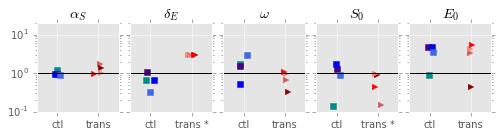

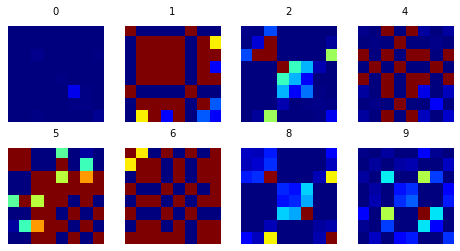

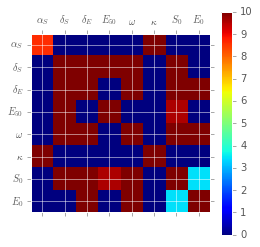

In [21]:

p_to_plot=[0,2,4,6,7]

#variable ratio subplots
po_rat_arr = po_arrA/po_arr[:,mati]
fig,axarr = plt.subplots(1,5,sharey=True,figsize=(7,2),dpi=600)
nz=0.1 #noise for scatter jitter
S=30 #marker size
alz=0.75 #transparency of scatter
for i in range(len(p_to_plot)):
    #ax=axarr[i%2][int(np.floor(i/2))]
    ax=axarr[i]
    for j in range(4):
        ax.scatter(1+np.random.uniform(low=-nz, high=nz),po_rat_arr[p_to_plot[i],j],color=cz_list[mati[j]],marker=mz_list[mati[j]],s=S)
        ax.scatter(2+np.random.uniform(low=-nz, high=nz),po_rat_arr[p_to_plot[i],j+4],color=cz_list[mati[j+4]],marker=mz_list[mati[j+4]],s=S)
    ax.axhline(y=1,color='k') #put a line at y=1
    ax.set_title(param_names[p_to_plot[i]])

    #simple significance check just check if all greater or less than 1 (nonparametric comparison with null hypothesis)
    if (po_rat_arr[p_to_plot[i],:3]<1).all() or (po_rat_arr[p_to_plot[i],:3]>1).all():
        xlab1='ctl *'
    else:
        xlab1='ctl'      
    if (po_rat_arr[p_to_plot[i],4:]<1).all() or (po_rat_arr[p_to_plot[i],4:]>1).all():
        xlab2='trans *'
    else:
        xlab2='trans'   
    ax.set_xticks([1,2])
    ax.set_xlim([0.5,2.5])
    ax.set_yscale('log')
    ax.set_xticklabels([xlab1,xlab2])
plt.ylim([0.1,20])
plt.tight_layout()
plt.savefig('figures/fits_ratioscatter.pdf')

#show all the fitting covariance matrices for ATI
maxz=10 #max error to put on colorbar

#covariance for each monkey
fig1,axarr = plt.subplots(2,4,figsize=(8,4),dpi=600)
for j in range(8):
    ax=axarr[int(np.floor(j/4))][j%4]
    bp=po_arrA[:,j] #best parameter set
    mean_sq = np.transpose(np.matrix(bp))*np.matrix(bp)#matrix of param values to normalize
    f=ax.matshow(pc_arrA[:,:,j]/mean_sq)
    f.set_clim([0,maxz])
    ax.set_yticks([]); ax.set_xticks([]) #ticks off
    ax.set_title(mati[j],fontsize=10)
plt.savefig('figures/cov_ATI.pdf')  # No warning now

#mean covariance matrix
fig2=plt.figure(figsize=(5,2),dpi=600)
bp_mean=np.mean(po_arrA,1)
mean_sq = np.transpose(np.matrix(bp_mean))*np.matrix(bp_mean) #matrix of mean param values to normalize
C=np.mean(pc_arrA,2)
plt.matshow(C/mean_sq)
plt.yticks(range(8),param_names)
plt.xticks(range(8),param_names)
plt.clim(0,maxz)
plt.colorbar()
plt.savefig('figures/cov_ATI_mean.pdf')


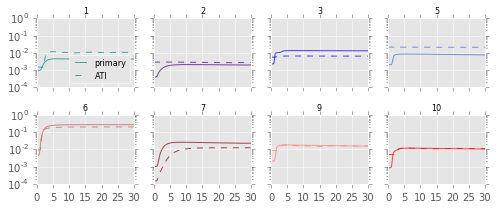

In [23]:
#simulate immune response
#simulating the whole trajectory given the ART intervention etc,

alz=0.7

fig,axarr = plt.subplots(2,4,sharex=True,sharey=True,figsize=(7,3),dpi=600)

t1=np.linspace(0,30*7,1e3) #week timeseries
t2=np.linspace(0,30*7,1e3) #week timeseries
dt=t1[1]

#initial conditions that are always true regardless of model
U0=0      #no infected cells
P0=0      #productively infected cells
V0=0.03   #start with 30 copies per mL

Bt=1e-4; dI=1; tau=0.05; p=5e4; g=23; aE=1e-4; #pegged parameters

for m in range(8):
    ax=axarr[int(np.floor(m/4))][m%4]
    ax.set_title(mati[m]+1,fontsize=8)

    aS,dS,dE,E50,w,k,S0,E0=po_arr[:,mati[m]]
    sol=odeint(model_1, [S0,U0,P0,E0,V0], t1, 
               (aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    imm=w*sol[:,3]/(sol[:,3]+E50)*dt #immune response over time
    #imm=sol[:,3]
    ax.semilogy(t1/7,imm,color=cz_list[mati[m]],alpha=alz)

    aS,dS,dE,E50,w,k,S0,E0=po_arrA[:,m] #ATI values
    sol=odeint(model_1, [S0,U0,P0,E0,V0], t2, 
               (aS,dS,Bt,tau,dI,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    imm=w*sol[:,3]/(sol[:,3]+E50)*dt #immune response over time

    #imm=sol[:,3]
    ax.semilogy(t2/7,imm,color=cz_list[mati[m]],ls='--',alpha=alz)

axarr[0][0].legend(['primary','ATI'],fontsize=8,loc=4)
fig.tight_layout()
fig.savefig('figures/sim_immunity.pdf')  # No warning now
